# Asynchronous and concurrent execution on GPUs
>*Melina Abeling, Julian Aeissen, Michele Pagani*. Supervised by *Oliver Fuhrer*

*GPUs allow for asynchronous (CPU simply launches work on GPU and then continues) and concurrent (multiple tasks are executed in parallel on the GPU) execution. In this project you will implement a simple stencil program and investigate performance using different stencil motifs as a function of grid size and amount of concurrency. It is foreseen to use either CuPy or CUDA for this project.*


---

## Introduction
*TODO*

---

## Methods
*TODO*

In [1]:
# Imports
import time
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math

In [2]:
# Utils

boxplot_options = {
    "showfliers": False,
    "patch_artist": True,
    "notch": False,
    "widths": 2.7,
}


def update_halo(field, num_halo):
    # Checks
    dim = len(field.shape)
    assert dim in [2,3]

    # 2d case
    if dim == 2:
        # bottom edge (without corners)
        field[:num_halo, num_halo:-num_halo] = field[
            -2 * num_halo : -num_halo, num_halo:-num_halo
        ]
    
        # top edge (without corners)
        field[-num_halo:, num_halo:-num_halo] = field[
            num_halo : 2 * num_halo, num_halo:-num_halo
        ]
    
        # left edge (including corners)
        field[:, :num_halo] = field[:, -2 * num_halo : -num_halo]
    
        # right edge (including corners)
        field[:, -num_halo:] = field[:, num_halo : 2 * num_halo]
    
    # 3d case
    elif dim == 3:
        # bottom edge (without corners)
        field[:, :num_halo, num_halo:-num_halo] = field[
            :, -2 * num_halo : -num_halo, num_halo:-num_halo
        ]
    
        # top edge (without corners)
        field[:, -num_halo:, num_halo:-num_halo] = field[
            :, num_halo : 2 * num_halo, num_halo:-num_halo
        ]
    
        # left edge (including corners)
        field[:, :, :num_halo] = field[:, :, -2 * num_halo : -num_halo]
    
        # right edge (including corners)
        field[:, :, -num_halo:] = field[:, :, num_halo : 2 * num_halo]



### Initial fields
*TODO*

In [3]:
# Creates an empty initial field with a square of size / 2 at the center of value `value`
def get_initial_field_square(size, n_halo, value = 1.0) -> cp.ndarray:
    # Check parameters
    assert type(size) == tuple
    dim = len(size)
    assert dim in [2,3]

    # Init
    h, w = size[-2], size[-1]

    # Add halo
    h += 2*n_halo
    w += 2*n_halo

    # 2d
    if dim == 2:
        field = cp.zeros((h, w), dtype=cp.float32)
        field[ h//4 : 3*h//4,
               w//4 : 3*w//4 ] = value

    # 3d
    elif dim == 3:
        field = cp.zeros((size[0], h, w), dtype=cp.float32)
        field[ :,
               h//4 : 3*h//4,
               w//4 : 3*w//4 ] = value

    return field

# Creates an grid of spacing `spacing`
def get_initial_field_grid(size, n_halo, value = 1.0, spacing=50) -> cp.ndarray:
    # Check parameters
    assert type(size) == tuple
    dim = len(size)
    assert dim in [2,3]

    # Init
    h, w = size[-2], size[-1]

    # Add halo
    h += 2*n_halo
    w += 2*n_halo

    # 2d
    if dim == 2:
        field = cp.zeros((h, w), dtype=cp.float32)

        # Horizontal strides
        for i in range(h // spacing + 2):
            if i * spacing >= h:
                break
            idx = spacing // 3 + i * spacing
            field[ idx : idx + spacing // 3, :] = value
            
        # Vertical strides
        for i in range(w // spacing + 2):
            if i * spacing >= w:
                break
            idx = spacing // 3 + i * spacing
            field[ :, idx : idx + spacing // 3] = value

    # 3d
    elif dim == 3:
        field = cp.zeros((size[0], h, w), dtype=cp.float32)
        
        # Horizontal strides
        for i in range(h // spacing + 2):
            if i * spacing >= h:
                break
            idx = spacing // 3 + i * spacing
            field[ :, idx : idx + spacing // 3, :] = value
            
        # Vertical strides
        for i in range(w // spacing + 2):
            if i * spacing >= w:
                break
            idx = spacing // 3 + i * spacing
            field[ :, :, idx : idx + spacing // 3] = value
        
    return field

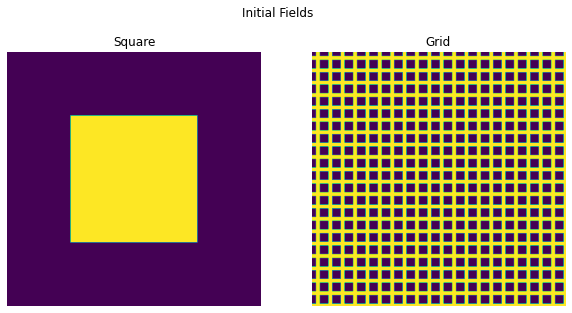

In [4]:
# Plots
fig, (axA, axB) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Initial Fields")

# Settings
field_size_demo = (1024, 1024)
# n_iter_demo = 20
n_halo_demo = 1

# Plotting square field
field_demo_square = get_initial_field_square(field_size_demo, n_halo_demo).get()
axA.imshow(field_demo_square)
axA.set_title("Square")
axA.set_axis_off()

# Plotting grid field
field_demo_grid = get_initial_field_grid(field_size_demo, n_halo_demo, spacing=50).get()
axB.imshow(field_demo_grid)
axB.set_title("Grid")
axB.set_axis_off()


### Stencils
*TODO*

*Example*

In [5]:
def step_stencil_2d_example(in_field, out_field, n_halo):
    # Checks
    assert len(in_field.shape) == 2
    assert len(out_field.shape) == 2
    h,w = out_field.shape
    h_in_,w_in_ = in_field.shape
    assert h_in_ == h + 2*n_halo
    assert w_in_ == w + 2*n_halo

    # Example with a simple Gaussian filter
    # IMPORTANT always have an expected halo
    assert n_halo == 1

    # Computation
    out_field[:,:] = (
        4.0 * in_field[1:-1, 1:-1]
        + 2.0 * in_field[2:, 1:-1]
        + 2.0 * in_field[:-2, 1:-1]
        + 2.0 * in_field[1:-1, 2:]
        + 2.0 * in_field[1:-1, :-2]
        + in_field[2:, 2:]
        + in_field[2:, :-2]
        + in_field[:-2, 2:]
        + in_field[:-2, :-2]
    ) / 16.0

    # out_field[:,:] = in_field[2:, 1:-1]

In [6]:
def step_stencil_3d_example(in_field, out_field, n_halo):
    # Checks
    assert len(in_field.shape) == 3
    assert len(out_field.shape) == 3
    _, h,w = out_field.shape
    _, h_in_,w_in_ = in_field.shape
    assert h_in_ == h + 2*n_halo
    assert w_in_ == w + 2*n_halo

    # Example with a simple Gaussian filter
    # IMPORTANT always have an expected halo
    assert n_halo == 1

    # Computation
    out_field[:,:,:] = (
        4.0 * in_field[:, 1:-1, 1:-1]
        + 2.0 * in_field[:, 2:, 1:-1]
        + 2.0 * in_field[:, :-2, 1:-1]
        + 2.0 * in_field[:, 1:-1, 2:]
        + 2.0 * in_field[:, 1:-1, :-2]
        + in_field[:, 2:, 2:]
        + in_field[:, 2:, :-2]
        + in_field[:, :-2, 2:]
        + in_field[:, :-2, :-2]
    ) / 16.0

#### A
*TODO*

In [7]:
def step_stencil_a(field):
    pass

### TODO DELETE
step_stencil_a = step_stencil_2d_example
###


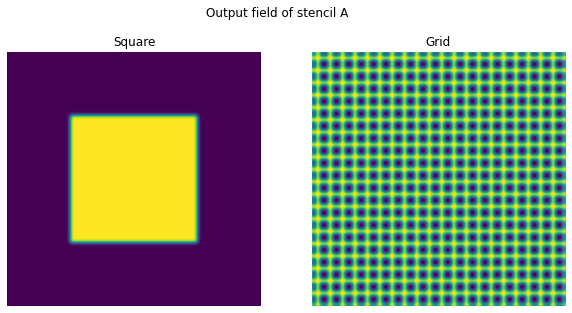

In [8]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Output field of stencil A")

# Settings
n_iter_demo_a = 100
n_halo_demo = 1

# Compute square
field_a_square = get_initial_field_square(field_size_demo, n_halo_demo)
in_field_a_square = cp.copy(field_a_square)
out_field_a_square = cp.copy(in_field_a_square)
for iter in range(n_iter_demo_a):
    update_halo(in_field_a_square, n_halo_demo)
    step_stencil_a(
        in_field_a_square,
        out_field_a_square[
            n_halo_demo: -n_halo_demo,
            n_halo_demo: -n_halo_demo,
        ],
        n_halo_demo
    )

    # Update out_field
    if iter < n_iter_demo_a - 1:
        in_field_a_square, out_field_a_square = out_field_a_square, in_field_a_square


# Compute grid
field_a_grid = get_initial_field_grid(field_size_demo, n_halo_demo, spacing=50)
in_field_a_grid = cp.copy(field_a_grid)
out_field_a_grid = cp.copy(in_field_a_grid)
for iter in range(n_iter_demo_a):
    update_halo(in_field_a_grid, n_halo_demo)
    step_stencil_a(
        in_field_a_grid,
        out_field_a_grid[
            n_halo_demo: -n_halo_demo,
            n_halo_demo: -n_halo_demo,
        ],
        n_halo_demo
    )

    # Update out_field
    if iter < n_iter_demo_a - 1:
        in_field_a_grid, out_field_a_grid = out_field_a_grid, in_field_a_grid


# Plotting square field
ax1.imshow(out_field_a_square.get())
ax1.set_title("Square")
ax1.set_axis_off()

# Plotting grid field
ax2.imshow(out_field_a_grid.get())
ax2.set_title("Grid")
ax2.set_axis_off()


#### B
*TODO*

In [9]:
def step_stencil_b(field):
    pass

### TODO DELETE
step_stencil_b = step_stencil_3d_example
###


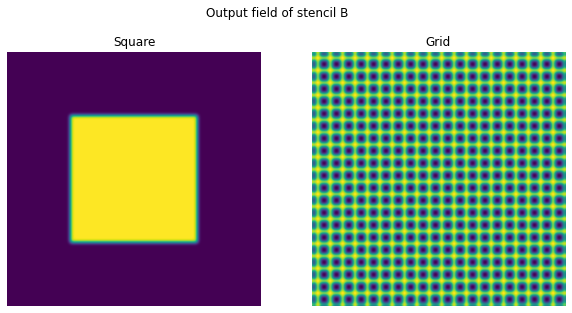

In [10]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Output field of stencil B")

# Settings
n_iter_demo_b = 100
n_halo_demo = 1

# Compute square
field_b_square = get_initial_field_square((32, *field_size_demo), n_halo_demo)
in_field_b_square = cp.copy(field_b_square)
out_field_b_square = cp.copy(in_field_b_square)
for iter in range(n_iter_demo_b):
    update_halo(in_field_b_square, n_halo_demo)
    step_stencil_b(
        in_field_b_square,
        out_field_b_square[
            :,
            n_halo_demo: -n_halo_demo,
            n_halo_demo: -n_halo_demo,
        ],
        n_halo_demo
    )

    # Update out_field
    if iter < n_iter_demo_b - 1:
        in_field_a_square, out_field_b_square = out_field_b_square, in_field_b_square


# Compute grid
field_b_grid = get_initial_field_grid((32, *field_size_demo), n_halo_demo, spacing=50)
in_field_b_grid = cp.copy(field_b_grid)
out_field_b_grid = cp.copy(in_field_b_grid)
for iter in range(n_iter_demo_b):
    update_halo(in_field_b_grid, n_halo_demo)
    step_stencil_b(
        in_field_b_grid,
        out_field_b_grid[
            :,
            n_halo_demo: -n_halo_demo,
            n_halo_demo: -n_halo_demo,
        ],
        n_halo_demo
    )

    # Update out_field
    if iter < n_iter_demo_b - 1:
        in_field_b_grid, out_field_b_grid = out_field_b_grid, in_field_b_grid


# Plotting square field
ax1.imshow(out_field_b_square[0].get())
ax1.set_title("Square")
ax1.set_axis_off()

# Plotting grid field
ax2.imshow(out_field_b_grid[0].get())
ax2.set_title("Grid")
ax2.set_axis_off()


### GPU parallelization
*TODO*

In [11]:
def compute_gpu(in_field, stencil, n_stream, n_iter, n_halo, force_tile=False):
    # Init
    out_field = cp.copy(in_field)
    tile = math.sqrt(n_stream).is_integer() or force_tile
    
    # Chech n_stream
    if tile:
        assert math.sqrt(n_stream).is_integer()
        stream_per_side = int(math.sqrt(n_stream))
    else:
        stream_per_side = n_stream
    
    # Check in_field
    dim = len(in_field.shape)
    assert dim in [2, 3]
    h,w = in_field.shape[-2], in_field.shape[-1]
    h -= 2*n_halo
    w -= 2*n_halo
    # assert h % stream_per_side == 0
    # assert w % stream_per_side == 0

    if tile:
        h_stream = h // stream_per_side
        w_stream = w // stream_per_side
    else:
        h_stream = h // stream_per_side
        w_stream = w

    is_3d = dim == 3
    
    # Create streams
    streams = [ cp.cuda.Stream() for _ in range(n_stream) ]

    for iter in range(n_iter):
        # Init
        e = cp.cuda.Event()
        e.record()

        update_halo(in_field, n_halo)

        # Iterate over streams
        for idx, s in enumerate(streams):
            # Indeces
            if tile:
                i, j = idx // stream_per_side, idx % stream_per_side
            else:
                # If no tiles, divide only the first dimension
                i, j = idx, 0
            with s:
                # Stencil iteration
                # print(f"i = {i}, j = {j}, len in = ({-i*h_stream + 2*n_halo + (i+1)*h_stream}, {-j*w_stream+ 2*n_halo + (j+1)*w_stream}), len out = {(-(n_halo + i*h_stream) + n_halo + (i+1)*h_stream, -( n_halo + j*w_stream) + n_halo + (j+1)*w_stream)}, pos in = [{(i*h_stream , 2*n_halo + (i+1)*h_stream)}, {(j*w_stream , 2*n_halo + (j+1)*w_stream)}], pos out = [{((n_halo + i*h_stream), n_halo + (i+1)*h_stream)}, { ( n_halo + j*w_stream, n_halo + (j+1)*w_stream) }], h_stream = {h_stream}, w_stream  = {w_stream}, h = {h}")
                if is_3d:
                    stencil(
                        in_field[
                            :,
                            i*h_stream: 2*n_halo + (i+1)*h_stream,
                            j*w_stream: 2*n_halo + (j+1)*w_stream
                        ],
                        out_field[
                            :,
                            n_halo + i*h_stream: n_halo + (i+1)*h_stream,
                            n_halo + j*w_stream: n_halo + (j+1)*w_stream
                        ],
                        n_halo
                    )
                else:
                    stencil(
                        in_field[
                            i*h_stream: 2*n_halo + (i+1)*h_stream,
                            j*w_stream: 2*n_halo + (j+1)*w_stream
                        ],
                        out_field[
                            n_halo + i*h_stream: n_halo + (i+1)*h_stream,
                            n_halo + j*w_stream: n_halo + (j+1)*w_stream
                        ],
                        n_halo
                    )

        # Syncronize all streams
        e.synchronize()

        # Update out_field
        if iter < n_iter - 1:
            in_field, out_field = out_field, in_field
            
    return out_field

---

## Results
*TODO*

### Performance over concurrency
*TODO*

In [12]:

# Settings
steps_concurrency = [1, 4, 9, 16, 25, 36, 49, 64]
field_size_a = (1024, 1024)
field_size_b = (16, 1024, 1024)
n_iter = 50
n_iter_stats = 20
n_halo = 1

# Setup
input_field_concur_a = get_initial_field_square(field_size_a, n_halo)
input_field_concur_b = get_initial_field_grid(field_size_b, n_halo)
# output_fields_a_concur = []
# output_fields_b_concur = []
times_a_concur = []
times_b_concur = []
times_transfer_a_concur = []
times_transfer_b_concur = []


for concurrency in steps_concurrency:

    # Compute for stencil A
    temp_times_a = []
    temp_times_transfer_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_concur_a)
        tic = time.perf_counter()
        temp_output_field_a_gpu = compute_gpu(new_input, step_stencil_a, concurrency, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_a = temp_output_field_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_a.append(toc-tic)
        # output_fields_a_concur.append(temp_output_field_a)
        del temp_output_field_a_gpu
        del temp_output_field_a
        del new_input

    times_a_concur.append(temp_times_a)
    times_transfer_a_concur.append(temp_times_transfer_a)
    
    # Compute for stencil B
    temp_times_b = []
    temp_times_transfer_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_concur_b)
        tic = time.perf_counter()
        temp_output_field_b_gpu = compute_gpu(new_input, step_stencil_b, concurrency, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_b = temp_output_field_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_b.append(toc-tic)
        # output_fields_b_concur.append(temp_output_field_b)
        del temp_output_field_b_gpu
        del temp_output_field_b
        del new_input
        
    times_b_concur.append(temp_times_b)
    times_transfer_b_concur.append(temp_times_transfer_b)


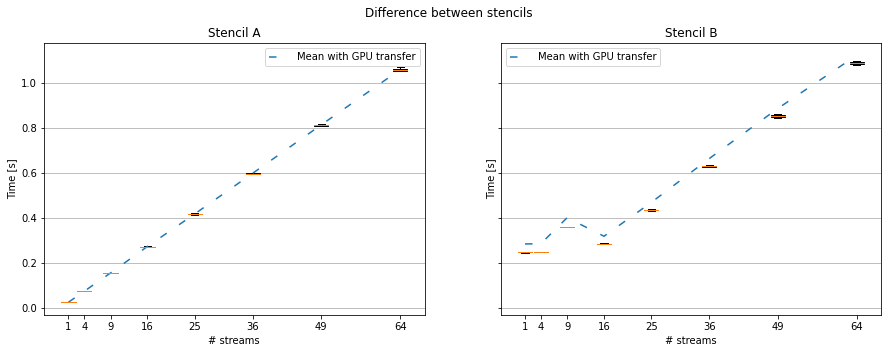

In [13]:

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("Difference between stencils")


# Stencil A
ax1.grid(axis='y')
ax1.set_title("Stencil A")
ax1.boxplot(np.array(times_a_concur).transpose(), positions = steps_concurrency, **boxplot_options);
mean_times_a = np.mean(times_a_concur, axis=1)
mean_times_transfer_a = np.mean(times_transfer_a_concur, axis=1)
ax1.plot(steps_concurrency, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='# streams', ylabel='Time [s]')
ax1.legend()

# Stencil B

ax2.grid(axis='y')
ax2.set_title("Stencil B")
ax2.boxplot(np.array(times_b_concur).transpose(), positions = steps_concurrency, **boxplot_options);
mean_times_b = np.mean(times_b_concur, axis=1)
mean_times_transfer_b = np.mean(times_transfer_b_concur, axis=1)
ax2.plot(steps_concurrency, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='# streams', ylabel='Time [s]')
ax2.legend()

# Settings
plt.ticklabel_format(axis='y', useOffset=False)

### Performance over grid size
*TODO*

In [14]:

# Settings
concurrency_1 = 1
concurrency_2 = 16
concurrency_3 = 64
steps_field_sizes = [64, 128, 256, 512, 1024, 2048, 5096]
# n_iter = 20
# n_iter_stats = 20
# n_halo = 1

# Setup
# output_fields_1_a_field = []
# output_fields_1_b_field = []
# output_fields_2_a_field = []
# output_fields_2_b_field = []
# output_fields_3_a_field = []
# output_fields_3_b_field = []
times_1_a_field = []
times_1_b_field = []
times_2_a_field = []
times_2_b_field = []
times_3_a_field = []
times_3_b_field = []
times_transfer_1_a_field = []
times_transfer_1_b_field = []
times_transfer_2_a_field = []
times_transfer_2_b_field = []
times_transfer_3_a_field = []
times_transfer_3_b_field = []


for field_size in steps_field_sizes:
    print(field_size)

    # Setup
    input_field_a = get_initial_field_square((field_size, field_size), n_halo)
    input_field_b = get_initial_field_grid((16, field_size, field_size), n_halo)

    
    ## Compute for concurrency 1
    # Stencil A
    temp_times_1_a = []
    temp_times_transfer_1_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_1_a_gpu = compute_gpu(new_input, step_stencil_a, concurrency_1, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_1_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_1_a = temp_output_field_1_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_1_a.append(toc-tic)
        # output_fields_1_a_field.append(temp_output_field_1_a)
        del temp_output_field_1_a_gpu
        del temp_output_field_1_a
        del new_input
        
    times_1_a_field.append(temp_times_1_a)
    times_transfer_1_a_field.append(temp_times_transfer_1_a)
    
    # Stencil B
    temp_times_1_b = []
    temp_times_transfer_1_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_1_b_gpu = compute_gpu(new_input, step_stencil_b, concurrency_1, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_1_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_1_b = temp_output_field_1_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_1_b.append(toc-tic)
        # output_fields_1_b_field.append(temp_output_field_1_b)
        del temp_output_field_1_b_gpu
        del temp_output_field_1_b
        del new_input
        
    times_1_b_field.append(temp_times_1_b)
    times_transfer_1_b_field.append(temp_times_transfer_1_b)

    
    ## Compute for concurrency 2
    # Stencil A
    temp_times_2_a = []
    temp_times_transfer_2_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_2_a_gpu = compute_gpu(new_input, step_stencil_a, concurrency_2, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_2_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_2_a = temp_output_field_2_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_2_a.append(toc-tic)
        # output_fields_2_a_field.append(temp_output_field_2_a)
        del temp_output_field_2_a_gpu
        del temp_output_field_2_a
        del new_input
        
    times_2_a_field.append(temp_times_2_a)
    times_transfer_2_a_field.append(temp_times_transfer_2_a)
    
    # Stencil B
    temp_times_2_b = []
    temp_times_transfer_2_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_2_b_gpu = compute_gpu(new_input, step_stencil_b, concurrency_2, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_2_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_2_b = temp_output_field_2_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_2_b.append(toc-tic)
        # output_fields_2_b_field.append(temp_output_field_2_b)
        del temp_output_field_2_b_gpu
        del temp_output_field_2_b
        del new_input
        
    times_2_b_field.append(temp_times_2_b)
    times_transfer_2_b_field.append(temp_times_transfer_2_b)


    ## Compute for concurrency 3
    # Stencil A
    temp_times_3_a = []
    temp_times_transfer_3_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_3_a_gpu = compute_gpu(new_input, step_stencil_a, concurrency_3, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_3_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_3_a = temp_output_field_3_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_3_a.append(toc-tic)
        # output_fields_3_a_field.append(temp_output_field_3_a)
        del temp_output_field_3_a_gpu
        del temp_output_field_3_a
        del new_input
        
    times_3_a_field.append(temp_times_3_a)
    times_transfer_3_a_field.append(temp_times_transfer_3_a)
    
    # Stencil B
    temp_times_3_b = []
    temp_times_transfer_3_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_3_b_gpu = compute_gpu(new_input, step_stencil_b, concurrency_3, n_iter, n_halo, force_tile=False)
        toc = time.perf_counter()
        temp_times_3_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_3_b = temp_output_field_3_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_3_b.append(toc-tic)
        # output_fields_3_b_field.append(temp_output_field_3_b)
        del temp_output_field_3_b_gpu
        del temp_output_field_3_b
        del new_input
        
    times_3_b_field.append(temp_times_3_b)
    times_transfer_3_b_field.append(temp_times_transfer_3_b)



64
128
256
512
1024
2048
5096


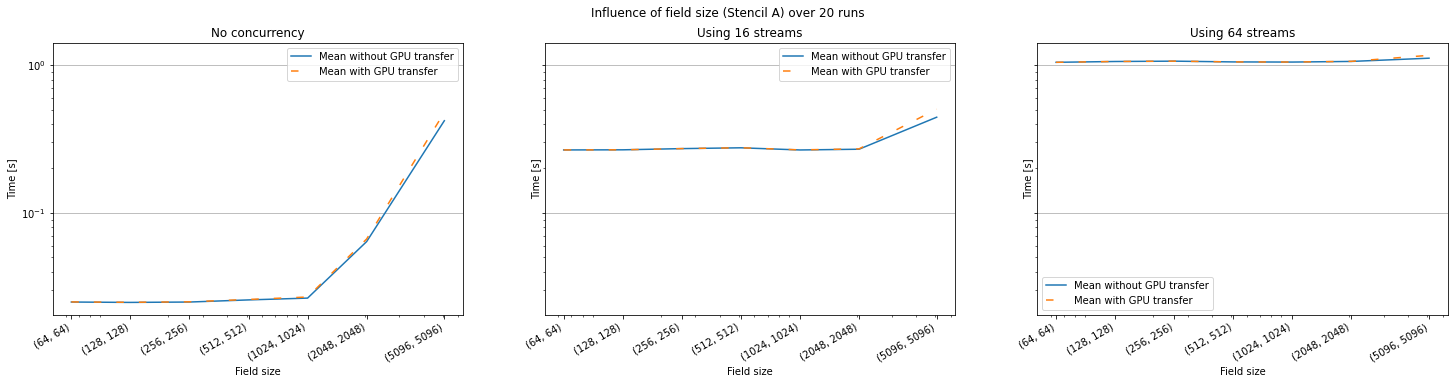

In [20]:
## Stencil A
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle(f"Influence of field size (Stencil A) over {n_iter_stats} runs")

str_steps_field_sizes = [
    f"({s}, {s})" for s in steps_field_sizes
]

# No concurrency
ax1.grid(axis='y')
ax1.set_title(f"No concurrency")
# ax1.boxplot(np.array(times_1_a_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_a = np.mean(times_1_a_field, axis=1)
mean_times_transfer_a = np.mean(times_transfer_1_a_field, axis=1)
ax1.plot(steps_field_sizes, mean_times_a, label="Mean without GPU transfer")
ax1.plot(steps_field_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='Field size', ylabel='Time [s]')
ax1.set_xscale('log')
ax1.xaxis.set_ticks(steps_field_sizes)
ax1.set_xticklabels(str_steps_field_sizes)
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax1.set_xticklabels(str_steps_field_sizes)
ax1.legend()

# No concurrency
ax2.grid(axis='y')
ax2.set_title(f"Using {concurrency_2} streams")
# ax2.boxplot(np.array(times_2_a_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_a = np.mean(times_2_a_field, axis=1)
mean_times_transfer_a = np.mean(times_transfer_2_a_field, axis=1)
ax2.plot(steps_field_sizes, mean_times_a, label="Mean without GPU transfer")
ax2.plot(steps_field_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='Field size', ylabel='Time [s]')
ax2.set_xscale('log')
ax2.xaxis.set_ticks(steps_field_sizes)
ax2.set_xticklabels(str_steps_field_sizes)
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2.legend()

# No concurrency
ax3.grid(axis='y')
ax3.set_title(f"Using {concurrency_3} streams")
# ax3.boxplot(np.array(times_3_a_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_a = np.mean(times_3_a_field, axis=1)
mean_times_transfer_a = np.mean(times_transfer_3_a_field, axis=1)
ax3.plot(steps_field_sizes, mean_times_a, label="Mean without GPU transfer")
ax3.plot(steps_field_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax3.set(xlabel='Field size', ylabel='Time [s]')
ax3.set_xscale('log')
ax3.xaxis.set_ticks(steps_field_sizes)
ax3.set_xticklabels(str_steps_field_sizes)
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.legend()


ax1.set_yscale('log')
# Settings
# plt.ticklabel_format(axis='y', useOffset=False)

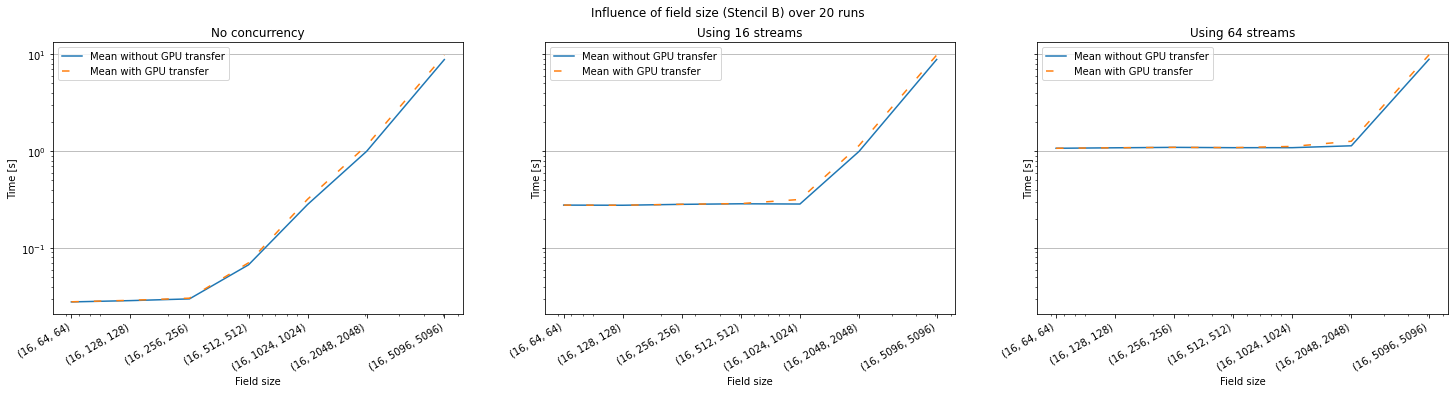

In [19]:
## Stencil B
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle(f"Influence of field size (Stencil B) over {n_iter_stats} runs")


str_steps_field_sizes = [
    f"(16, {s}, {s})" for s in steps_field_sizes
]

# No concurrency
ax1.grid(axis='y')
ax1.set_title(f"No concurrency")
# ax1.boxplot(np.array(times_1_b_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_b = np.mean(times_1_b_field, axis=1)
mean_times_transfer_b = np.mean(times_transfer_1_b_field, axis=1)
ax1.plot(steps_field_sizes, mean_times_b, label="Mean without GPU transfer")
ax1.plot(steps_field_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='Field size', ylabel='Time [s]')
ax1.set_xscale('log')
ax1.xaxis.set_ticks(steps_field_sizes)
ax1.set_xticklabels(str_steps_field_sizes)
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax1.set_xticklabels(str_steps_field_sizes)
ax1.legend()

# No concurrency
ax2.grid(axis='y')
ax2.set_title(f"Using {concurrency_2} streams")
# ax2.boxplot(np.array(times_2_b_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_b = np.mean(times_2_b_field, axis=1)
mean_times_transfer_b = np.mean(times_transfer_2_b_field, axis=1)
ax2.plot(steps_field_sizes, mean_times_b, label="Mean without GPU transfer")
ax2.plot(steps_field_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='Field size', ylabel='Time [s]')
ax2.set_xscale('log')
ax2.xaxis.set_ticks(steps_field_sizes)
ax2.set_xticklabels(str_steps_field_sizes)
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2.legend()

# No concurrency
ax3.grid(axis='y')
ax3.set_title(f"Using {concurrency_3} streams")
# ax3.boxplot(np.array(times_3_b_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_b = np.mean(times_3_b_field, axis=1)
mean_times_transfer_b = np.mean(times_transfer_3_b_field, axis=1)
ax3.plot(steps_field_sizes, mean_times_b, label="Mean without GPU transfer")
ax3.plot(steps_field_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax3.set(xlabel='Field size', ylabel='Time [s]')
ax3.set_xscale('log')
ax3.xaxis.set_ticks(steps_field_sizes)
ax3.set_xticklabels(str_steps_field_sizes)
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.legend()

ax1.set_yscale('log')
# Settings
# plt.ticklabel_format(axis='y', useOffset=False)

---

## Discussion
*TODO*

---

## Conclusion
*TODO*